# Building CNN Based On AlexNet Architecture

In [1]:
#Import tensorflow and keras library
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.preprocessing import image
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import keras

print("[INFO]: Tensorflow version{}".format(tf.__version__))
state_gpu = tf.test.gpu_device_name()
print("[INFO]: GPU usage{0}".format(state_gpu))

Using TensorFlow backend.


[INFO]: Tensorflow version2.1.0
[INFO]: GPU usage/device:GPU:0


In [5]:
# Initializing the CNN
classifier = Sequential()

# Convolution Step 1
classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

# Max Pooling Step 1
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Convolution Step 2
classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

# Max Pooling Step 2
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
classifier.add(BatchNormalization())

# Convolution Step 3
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 4
classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
classifier.add(BatchNormalization())

# Convolution Step 5
classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

# Max Pooling Step 3
classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
classifier.add(BatchNormalization())

# Flattening Step
classifier.add(Flatten())

# Full Connection Step
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 4096, activation = 'relu'))
classifier.add(Dropout(0.4))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 1000, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(BatchNormalization())
classifier.add(Dense(units = 38, activation = 'softmax'))
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

### Loading Weights To The Model

In [6]:
classifier.load_weights('../input/plant-diseases-classification-using-alexnet/best_weights_9.hdf5')

In [7]:
# Truncate and replace softmax layer for transfer learning
num_classes = 10   
classifier2 = Sequential()
for layer in classifier.layers[:-2]: # go through until last layer
    classifier2.add(layer)

classifier2.summary()
classifier2.add(Dense(num_classes, activation='softmax'))
classifier2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

In [8]:
# Compiling the Model
from keras import optimizers
"""
classifier.compile(optimizer=optimizers.SGD(lr=0.001, momentum=0.9, decay=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
"""
LEARNING_RATE = 0.0001
#LEARNING_RATE = 0.001

#Optimizer
opt = Adam(lr = LEARNING_RATE)
classifier2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [9]:
train_gen = ImageDataGenerator(
rescale = 1./255,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale = 1./255)

In [10]:
# ImageDataGenerator and get train data and validation data
TRAINING_DIR = '../input/tomato/New Plant Diseases Dataset(Augmented)/train/' 
VALIDATION_DIR = '../input/tomato/New Plant Diseases Dataset(Augmented)/valid/'

In [11]:
TARGET_SIZE = (224,224)
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128
SEED = 42

#Data Iterator
train_data = train_gen.flow_from_directory(
TRAINING_DIR,
target_size = TARGET_SIZE,
class_mode = 'categorical',
color_mode = "rgb",
batch_size = TRAIN_BATCH_SIZE,
shuffle = True,
seed = SEED
)

valid_data = valid_gen.flow_from_directory(
VALIDATION_DIR,
target_size = TARGET_SIZE,
class_mode = 'categorical',
color_mode = "rgb",
batch_size = VALID_BATCH_SIZE
)

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [12]:
TRAINING_NUM = train_data.n #or train_data.samples
VALID_NUM = valid_data.n
EPOCHS = 25

STEP_SIZE_TRAIN = TRAINING_NUM // TRAIN_BATCH_SIZE 
STEP_SIZE_VALID = VALID_NUM // VALID_BATCH_SIZE

#Train Model
history = classifier2.fit_generator(generator = train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    verbose=1
)

Epoch 1/25
143/143 [==============================] - 315s 2s/step - loss: 0.4210 - accuracy: 0.8731 - val_loss: 0.1133 - val_accuracy: 0.9444
Epoch 2/25
143/143 [==============================] - 274s 2s/step - loss: 0.2362 - accuracy: 0.9240 - val_loss: 0.2160 - val_accuracy: 0.9444
Epoch 3/25
143/143 [==============================] - 278s 2s/step - loss: 0.2227 - accuracy: 0.9276 - val_loss: 0.1674 - val_accuracy: 0.9506
Epoch 4/25
143/143 [==============================] - 279s 2s/step - loss: 0.1822 - accuracy: 0.9380 - val_loss: 0.2014 - val_accuracy: 0.9338
Epoch 5/25
143/143 [==============================] - 299s 2s/step - loss: 0.1804 - accuracy: 0.9415 - val_loss: 0.1499 - val_accuracy: 0.9491
Epoch 6/25
143/143 [==============================] - 281s 2s/step - loss: 0.1696 - accuracy: 0.9430 - val_loss: 0.0705 - val_accuracy: 0.9580
Epoch 7/25
143/143 [==============================] - 288s 2s/step - loss: 0.1542 - accuracy: 0.9476 - val_loss: 0.0751 - val_accuracy: 0.9702

In [15]:
best_val_acc = max(history.history['val_accuracy'])
print(best_val_acc*100)

97.93583154678345


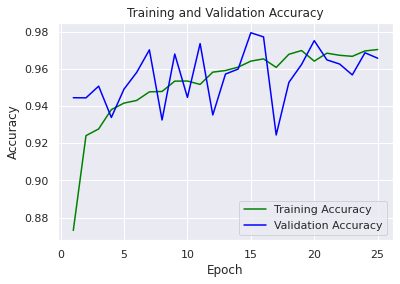

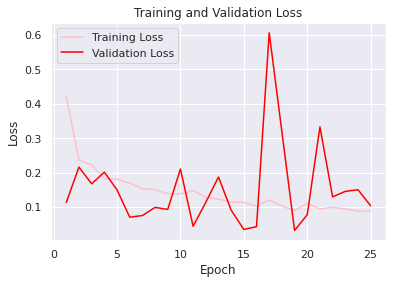

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [18]:
#Save Model
filepath="Model_stage2_ft1.hdf5"
classifier2.save(filepath)

filepath2="Model_wieghts_stage2_ft1.h5"
classifier2.save_weights(filepath2)


# FINE TUNNING

In [ ]:
TARGET_SIZE = (224,224)
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128
SEED = 42

#Data Iterator
train_data = train_gen.flow_from_directory(
TRAINING_DIR,
target_size = TARGET_SIZE,
class_mode = 'categorical',
color_mode = "rgb",
batch_size = TRAIN_BATCH_SIZE,
shuffle = True,
seed = SEED
)

valid_data = valid_gen.flow_from_directory(
VALIDATION_DIR,
target_size = TARGET_SIZE,
class_mode = 'categorical',
color_mode = "rgb",
batch_size = VALID_BATCH_SIZE
)

In [ ]:
# Truncate and replace softmax layer for transfer learning
num_classes = 10   
model_10cl_ft = Sequential()
for layer in base_model.layers[:-2]: # go through until last layer
    model_10cl_ft.add(layer)

model_10cl_ft.summary()
print("[INFO] Modify for 10 classes")
model_10cl_ft.add(Dense(num_classes, activation='softmax'))
model_10cl_ft.summary()

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
from keras import layers
for i, layer in enumerate(model_10cl_ft.layers):
   print(i, layer.name)

In [ ]:
print("Freezed layers:")
for i, layer in enumerate(model_10cl_ft.layers[:13]):
    print(i, layer.name)
    layer.trainable = False

In [ ]:
model_10cl_ft.summary()

In [ ]:
from keras.optimizers import SGD
LEARNING_RATE = 0.0001

# compile model
opt = SGD(lr=LEARNING_RATE, momentum=0.9)
model_10cl_ft.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
TRAINING_NUM = train_data.n #or train_data.samples
VALID_NUM = valid_data.n
EPOCHS = 25

STEP_SIZE_TRAIN = TRAINING_NUM // TRAIN_BATCH_SIZE 
STEP_SIZE_VALID = VALID_NUM // VALID_BATCH_SIZE

#Train Model
history = model_10cl_ft.fit_generator(generator = train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    verbose=1
)

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
print("[INFO] Best Validation Accuracy: %",best_val_acc*100)
#9797


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Plot Accuracy and Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()